# NCAR Innovator Program Project

### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Importing packages

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### Functions

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)


def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []

    for i, j in zip(t_daily.time, t_daily):

        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))

        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)

    return era5_time_array


def ends(df, x=5):
    """
    Viewing the beginnings and ends.
    """
    return pd.concat([df.head(x),df.tail(x)])

### NOAA Data

Downloaded data from: https://www.ncei.noaa.gov/access/search/data-search/global-hourly

Data documentation: https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00532/html#

In [3]:
# importing MIA airport data (ASOS station from NOAA/FAA)
MIA_temp = pd.read_csv('/glade/scratch/molina/72202012839.csv', low_memory=False)

In [4]:
ends(MIA_temp ,2)

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,OC1,OD1,OE1,OE2,OE3,RH1,RH2,RH3,REM,EQD
0,72202012839,2019-01-01T00:00:00,4,25.7881,-80.3169,8.8,"MIAMI INTERNATIONAL AIRPORT, FL US",FM-12,99999,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SYN08072202 32566 21106 10244 20217 30200 4021...,NaN
1,72202012839,2019-01-01T00:53:00,7,25.7881,-80.3169,8.8,"MIAMI INTERNATIONAL AIRPORT, FL US",FM-15,KMIA,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET09312/31/18 19:53:01 METAR KMIA 010053Z 110...,D01 0ADE726
13592,72202012839,2019-12-31T22:53:00,7,25.7881,-80.3169,8.8,"MIAMI INTERNATIONAL AIRPORT, FL US",FM-15,KMIA,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10612/31/19 17:53:02 METAR KMIA 312253Z 330...,D01 0ADE726
13593,72202012839,2019-12-31T23:53:00,7,25.7881,-80.3169,8.8,"MIAMI INTERNATIONAL AIRPORT, FL US",FM-15,KMIA,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET11712/31/19 18:53:02 METAR KMIA 312353Z 340...,D01 0ADE726


In [5]:
time_date = []
temperature_C = []

for j, i in zip(MIA_temp['DATE'].values, MIA_temp['TMP'].values.astype(str)):

    time_date.append(j)

    # convert the string format to decimal format (originally in METAR code)
    temperature_C.append(float(i[0]+i.split(',')[0][2:-1]+'.'+i.split(',')[0][-1]))
    
time_date = np.array(time_date)
temperature_C = np.array(temperature_C)

temperature_F = cel_to_far(temperature_C)
temperature_C = cel_to_nan(temperature_C)

In [6]:
# making into dataframe for easier manipulation

# initialize data of lists.
data = {'Datetime': pd.to_datetime(time_date),
        'Temperature_C': temperature_C,
        'Temperature_F': temperature_F,
       }

# Create DataFrame and quality control
df = pd.DataFrame(data)
df = df.dropna()  # drop any nan values (which occurs at same time each day)
df = df.drop_duplicates(keep='first')
# drop any duplicate rows
df = df[~df['Datetime'].duplicated()].drop_duplicates()
df = df[(df['Datetime']>='2019-06-09')&(df['Datetime']<='2019-08-31T23:59:00')] 
# subset the data using dates of interest

In [7]:
ends(df, 2)

,Datetime,Temperature_C,Temperature_F
5789,2019-06-09 00:00:00,26.7,80.06
5790,2019-06-09 00:53:00,26.7,80.06
9122,2019-08-31 22:53:00,30.6,87.08
9123,2019-08-31 23:53:00,29.4,84.92


### Shading Dade

In [8]:
SD_temp = pd.read_excel('/glade/scratch/molina/ShadingDadeData.xlsx')
SD_temp = SD_temp[(SD_temp['Datetime']>='2019-06-09')&(SD_temp['Datetime']<='2019-08-31T23:59:00')]

In [9]:
ends(SD_temp, 2)

,Datetime,Temperature (C),Temperature (F)
13,2019-06-09 00:00:00.000,25.500,77.900
14,2019-06-09 01:00:00.288,26.125,79.025
2027,2019-08-31 22:00:00.288,27.875,82.175
2028,2019-08-31 22:59:59.712,26.750,80.150


### Check data

In [10]:
df.isnull().sum()

Datetime         0
Temperature_C    0
Temperature_F    0
dtype: int64

In [11]:
SD_temp.isnull().sum()

Datetime           0
Temperature (C)    0
Temperature (F)    0
dtype: int64

### Create new variables

In [12]:
# Daily temperature maximum for Shading Dade
tmax_SD_daily = SD_temp.set_index('Datetime').resample('1D').max()

In [13]:
tmax_SD_daily.isnull().sum()

Temperature (C)    0
Temperature (F)    0
dtype: int64

In [14]:
# Daily temperature minimum for Shading Dade
tmin_SD_daily = SD_temp.set_index('Datetime').resample('1D').min()

In [15]:
tmin_SD_daily.isnull().sum()

Temperature (C)    0
Temperature (F)    0
dtype: int64

In [16]:
# Daily temperature maximum for NOAA (KMIA)
tmax_NOAA_daily = df.set_index('Datetime').resample('1D').max()

In [17]:
tmax_NOAA_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [18]:
# Daily temperature minimum for NOAA (KMIA)
tmin_NOAA_daily = df.set_index('Datetime').resample('1D').min()

In [19]:
tmin_NOAA_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [20]:
# corresponding date/time for shading dade daily temperature maximum
tmax_SD_daily_datetime = SD_temp.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmax()
)['Temperature (C)']

In [22]:
tmax_SD_daily_datetime.isnull().sum()

0

In [23]:
# corresponding date/time for shading dade daily temperature minimum
tmin_SD_daily_datetime = SD_temp.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmin()
)['Temperature (C)']

In [24]:
tmin_SD_daily_datetime.isnull().sum()

0

In [25]:
# corresponding date/time for noaa daily temperature maximum
tmax_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [26]:
tmax_NOAA_daily_datetime.isnull().sum()

0

In [27]:
# corresponding date/time for noaa daily temperature minimum
tmin_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

In [28]:
tmin_NOAA_daily_datetime.isnull().sum()

0

In [29]:
# the NOAA temperature during the (same time as the) daily maximum temperature of Shading Dade

NOAA_temp_during_SD_tmax_C = []
NOAA_temp_during_SD_tmax_F = []

for i in tmax_SD_daily_datetime.values:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        NOAA_temp_during_SD_tmax_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_SD_tmax_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_F'])
    
NOAA_temp_during_SD_tmax_C = np.array(NOAA_temp_during_SD_tmax_C)
NOAA_temp_during_SD_tmax_F = np.array(NOAA_temp_during_SD_tmax_F)

In [30]:
print(np.any(np.isnan(NOAA_temp_during_SD_tmax_C)))
print(np.any(np.isnan(NOAA_temp_during_SD_tmax_F)))

False
False


In [31]:
# the NOAA temperature during the (same time as the) daily minimum temperature of Shading Dade

NOAA_temp_during_SD_tmin_C = []
NOAA_temp_during_SD_tmin_F = []

for i in tmin_SD_daily_datetime.values:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        NOAA_temp_during_SD_tmin_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_SD_tmin_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_F'])
    
NOAA_temp_during_SD_tmin_C = np.array(NOAA_temp_during_SD_tmin_C)
NOAA_temp_during_SD_tmin_F = np.array(NOAA_temp_during_SD_tmin_F)

In [32]:
print(np.any(np.isnan(NOAA_temp_during_SD_tmin_C)))
print(np.any(np.isnan(NOAA_temp_during_SD_tmin_F)))

False
False


In [33]:
# the Shading Dade temperature during the (same time as the) daily maximum temperature of NOAA KMIA

SD_temp_during_NOAA_tmax_C = []
SD_temp_during_NOAA_tmax_F = []

for i in tmax_NOAA_daily_datetime.values:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        SD_temp_during_NOAA_tmax_C.append(
            SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature (C)'])

        SD_temp_during_NOAA_tmax_F.append(
            SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature (F)'])
    
SD_temp_during_NOAA_tmax_C = np.array(SD_temp_during_NOAA_tmax_C)
SD_temp_during_NOAA_tmax_F = np.array(SD_temp_during_NOAA_tmax_F)

In [34]:
print(np.any(np.isnan(SD_temp_during_NOAA_tmax_C)))
print(np.any(np.isnan(SD_temp_during_NOAA_tmax_F)))

False
False


In [35]:
# the Shading Dade temperature during the (same time as the) daily minimum temperature of NOAA KMIA

SD_temp_during_NOAA_tmin_C = []
SD_temp_during_NOAA_tmin_F = []

for i in tmin_NOAA_daily_datetime.values:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')

        SD_temp_during_NOAA_tmin_C.append(
            SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature (C)'])

        SD_temp_during_NOAA_tmin_F.append(
            SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature (F)'])
    
SD_temp_during_NOAA_tmin_C = np.array(SD_temp_during_NOAA_tmin_C)
SD_temp_during_NOAA_tmin_F = np.array(SD_temp_during_NOAA_tmin_F)

In [36]:
print(np.any(np.isnan(SD_temp_during_NOAA_tmin_C)))
print(np.any(np.isnan(SD_temp_during_NOAA_tmin_F)))

False
False


### differences (temperature)

In [37]:
# subtracting NOAA KMIA daily maximum temperature from the Shading Dade daily maximum temperature (C)
tmax_daily_difference_C = tmax_NOAA_daily['Temperature_C'] - tmax_SD_daily['Temperature (C)']

# subtracting NOAA KMIA daily maximum temperature from the Shading Dade daily maximum temperature (F)
tmax_daily_difference_F = tmax_NOAA_daily['Temperature_F'] - tmax_SD_daily['Temperature (F)']

# subtracting NOAA KMIA daily minimum temperature from the Shading Dade daily minimum temperature (C)
tmin_daily_difference_C = tmin_NOAA_daily['Temperature_C'] - tmin_SD_daily['Temperature (C)']

# subtracting NOAA KMIA daily minimum temperature from the Shading Dade daily minimum temperature (F)
tmin_daily_difference_F = tmin_NOAA_daily['Temperature_F'] - tmin_SD_daily['Temperature (F)']

In [38]:
# subtracting NOAA corresponding temperature during Shading Dade daily max temperature 
# from Shading Dade daily max temperature (C)
NOAA_temp_during_SD_tmax_C_diff = tmax_SD_daily['Temperature (C)'] - NOAA_temp_during_SD_tmax_C

# subtracting NOAA corresponding temperature during Shading Dade daily max temperature 
# from Shading Dade daily max temperature (F)
NOAA_temp_during_SD_tmax_F_diff = tmax_SD_daily['Temperature (F)'] - NOAA_temp_during_SD_tmax_F

# subtracting NOAA corresponding temperature during Shading Dade daily min temperature 
# from Shading Dade daily min temperature (C)
NOAA_temp_during_SD_tmin_C_diff = tmin_SD_daily['Temperature (C)'] - NOAA_temp_during_SD_tmin_C

# subtracting NOAA corresponding temperature during Shading Dade daily min temperature 
# from Shading Dade daily min temperature (F)
NOAA_temp_during_SD_tmin_F_diff = tmin_SD_daily['Temperature (F)'] - NOAA_temp_during_SD_tmin_F

In [39]:
# subtracting Shading Dade corresponding temperature during NOAA KMIA daily max temperature 
# from NOAA daily max temperature (C)
SD_temp_during_NOAA_tmax_C_diff = tmax_NOAA_daily['Temperature_C'] - SD_temp_during_NOAA_tmax_C

# subtracting Shading Dade corresponding temperature during NOAA KMIA daily max temperature 
# from NOAA daily max temperature (F)
SD_temp_during_NOAA_tmax_F_diff = tmax_NOAA_daily['Temperature_F'] - SD_temp_during_NOAA_tmax_F

# subtracting Shading Dade corresponding temperature during NOAA KMIA daily min temperature 
# from NOAA daily min temperature (C)
SD_temp_during_NOAA_tmin_C_diff = tmin_NOAA_daily['Temperature_C'] - SD_temp_during_NOAA_tmin_C

# subtracting Shading Dade corresponding temperature during NOAA KMIA daily min temperature 
# from NOAA daily min temperature (F)
SD_temp_during_NOAA_tmin_F_diff = tmin_NOAA_daily['Temperature_F'] - SD_temp_during_NOAA_tmin_F

### differences (time)

In [40]:
# absolute time difference between daily maximum temperature (NOAA KMIA and Shading Dade)
tmax_diff = []
for i, j in zip(tmax_SD_daily_datetime.values, tmax_NOAA_daily_datetime.values):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

# absolute time difference between daily minimum temperature (NOAA KMIA and Shading Dade)
tmin_diff = []
for i, j in zip(tmin_SD_daily_datetime.values, tmin_NOAA_daily_datetime.values):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### Create single CSV file with data

In [41]:
data = {'ShadingDade_Temperature_Daily_Max (C)': tmax_SD_daily['Temperature (C)'],
        'ShadingDade_Temperature_Daily_Min (C)': tmin_SD_daily['Temperature (C)'],
        'NOAA_KMIA_Temperature_Daily_Max (C)': tmax_NOAA_daily['Temperature_C'],
        'NOAA_KMIA_Temperature_Daily_Min (C)': tmin_NOAA_daily['Temperature_C'],
        
        'ShadingDade_Temperature_Daily_Max (F)': tmax_SD_daily['Temperature (F)'],
        'ShadingDade_Temperature_Daily_Min (F)': tmin_SD_daily['Temperature (F)'],
        'NOAA_KMIA_Temperature_Daily_Max (F)': tmax_NOAA_daily['Temperature_F'],
        'NOAA_KMIA_Temperature_Daily_Min (F)': tmin_NOAA_daily['Temperature_F'],
        
        'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C,
        'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C,
        'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F,
        'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F,
        
        'Corresponding_Datetime_ShadingDade_DailyMax': tmax_SD_daily_datetime.values,
        'Corresponding_Datetime_ShadingDade_DailyMin': tmin_SD_daily_datetime.values,
        'Corresponding_Datetime_NOAA_KMIA_DailyMax': tmax_NOAA_daily_datetime.values,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin': tmin_NOAA_daily_datetime.values,
        
        'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (C)': NOAA_temp_during_SD_tmax_C_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)': NOAA_temp_during_SD_tmax_F_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (C)': NOAA_temp_during_SD_tmin_C_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (F)': NOAA_temp_during_SD_tmin_F_diff,
        
        'Corresponding_Datetime_ShadingDade_DailyMax_Difference (C)': SD_temp_during_NOAA_tmax_C_diff,
        'Corresponding_Datetime_ShadingDade_DailyMax_Difference (F)': SD_temp_during_NOAA_tmax_F_diff,
        'Corresponding_Datetime_ShadingDade_DailyMin_Difference (C)': SD_temp_during_NOAA_tmin_C_diff,
        'Corresponding_Datetime_ShadingDade_DailyMin_Difference (F)': SD_temp_during_NOAA_tmin_F_diff,
        
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (C)': NOAA_temp_during_SD_tmax_C,
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (C)': NOAA_temp_during_SD_tmin_C,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (C)': SD_temp_during_NOAA_tmax_C,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (C)': SD_temp_during_NOAA_tmin_C,
        
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (F)': NOAA_temp_during_SD_tmax_F,
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (F)': NOAA_temp_during_SD_tmin_F,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (F)': SD_temp_during_NOAA_tmax_F,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (F)': SD_temp_during_NOAA_tmin_F,
        
        'Absolute_time_difference_tmax_NOAA_ShadingDade (day H:M:S)': tmax_diff,
        'Absolute_time_difference_tmin_NOAA_ShadingDade (day H:M:S)': tmin_diff,
        
        
       }

In [42]:
df_FINAL = pd.DataFrame(data)

In [43]:
ends(df_FINAL, 2)

,ShadingDade_Temperature_Daily_Max (C),ShadingDade_Temperature_Daily_Min (C),NOAA_KMIA_Temperature_Daily_Max (C),NOAA_KMIA_Temperature_Daily_Min (C),ShadingDade_Temperature_Daily_Max (F),ShadingDade_Temperature_Daily_Min (F),NOAA_KMIA_Temperature_Daily_Max (F),NOAA_KMIA_Temperature_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Min_Difference (C),...,NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (F),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (F),Absolute_time_difference_tmax_NOAA_ShadingDade (day H:M:S),Absolute_time_difference_tmin_NOAA_ShadingDade (day H:M:S)
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-09,33.75,25.125,31.1,25.0,92.75,77.225,87.98,77.00,-2.65,-0.125,...,27.8,27.2,25.625,28.250,82.04,80.96,78.125,82.850,0 days 03:53:00,0 days 02:29:00
2019-06-10,38.50,23.250,31.7,23.9,101.30,73.850,89.06,75.02,-6.80,0.650,...,25.6,26.7,27.375,25.250,78.08,80.06,81.275,77.450,0 days 03:53:00,0 days 04:36:00
2019-08-30,35.00,23.875,32.2,25.0,95.00,74.975,89.96,77.00,-2.80,1.125,...,27.2,26.7,29.750,30.250,80.96,80.06,85.550,86.450,0 days 05:53:01,0 days 03:02:01
2019-08-31,36.50,26.750,32.2,26.7,97.70,80.150,89.96,80.06,-4.30,-0.050,...,30.0,27.8,31.625,33.625,86.00,82.04,88.925,92.525,0 days 03:53:00,0 days 01:53:01


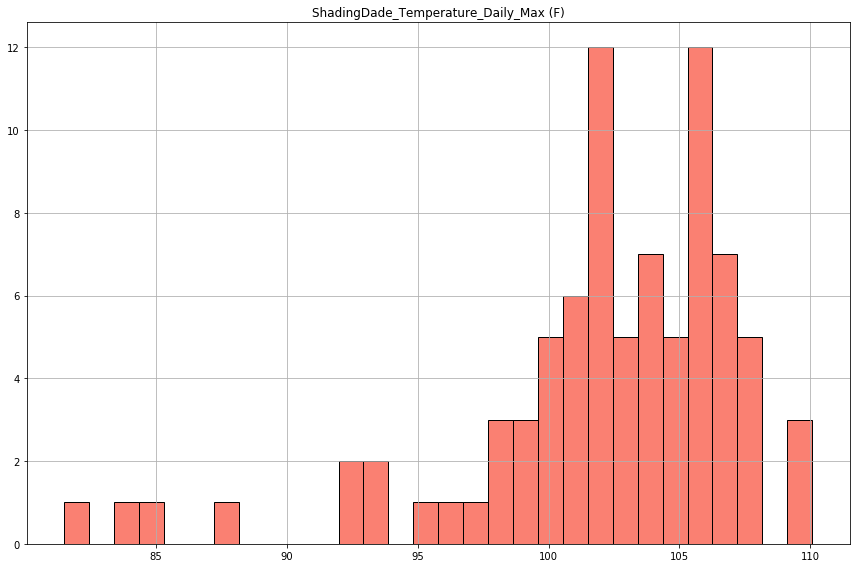

In [44]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Max (F)', 
              edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

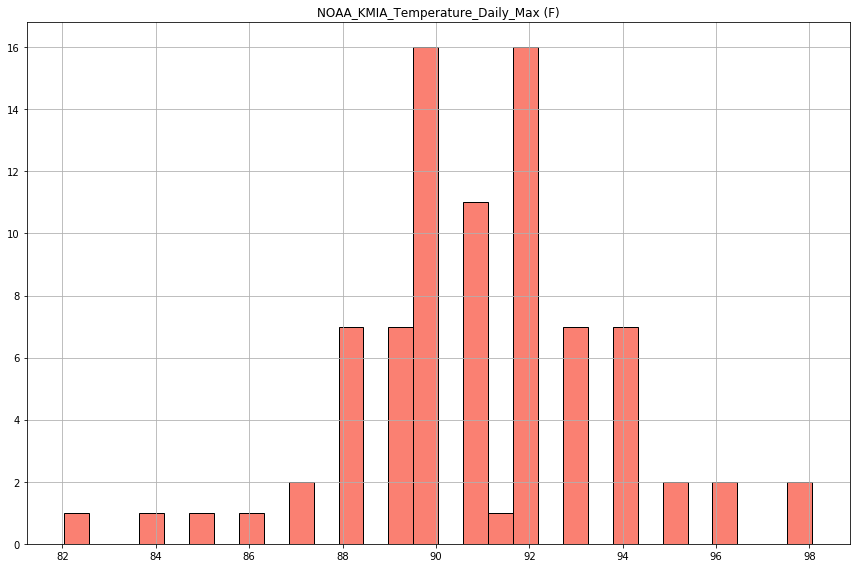

In [45]:
df_FINAL.hist('NOAA_KMIA_Temperature_Daily_Max (F)', 
              edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

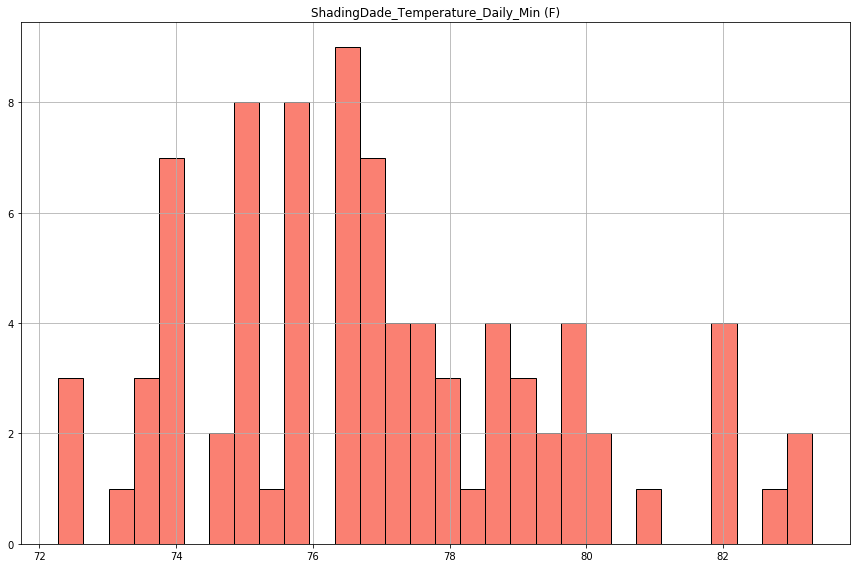

In [46]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Min (F)', 
              edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

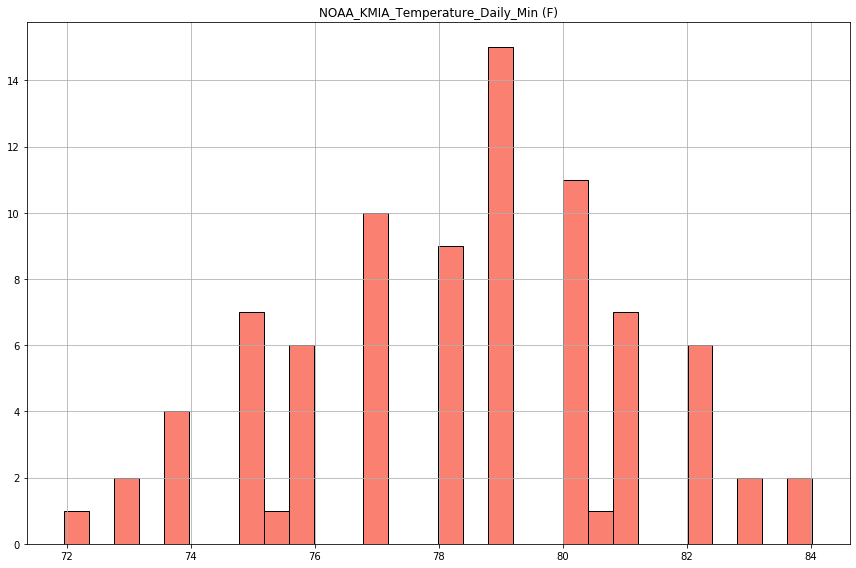

In [47]:
df_FINAL.hist('NOAA_KMIA_Temperature_Daily_Min (F)', 
              edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

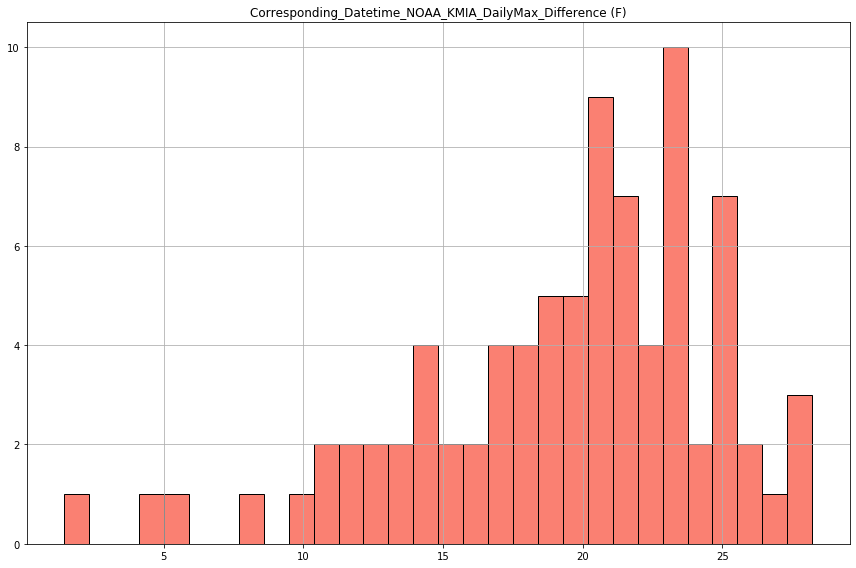

In [48]:
df_FINAL.hist(
    'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)', 
    edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

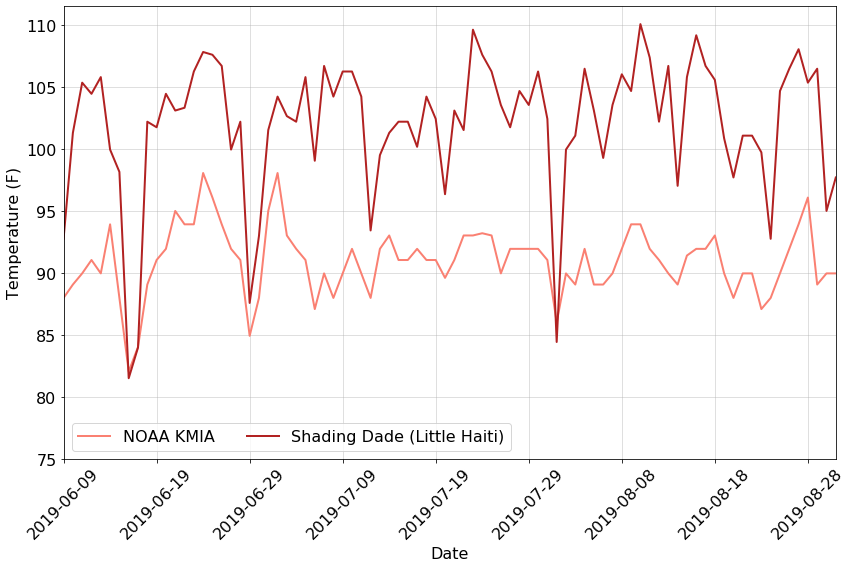

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

ls0, = ax.plot(tmax_NOAA_daily['Temperature_F'].values, color='salmon', lw=2.0)
ls1, = ax.plot(tmax_SD_daily['Temperature (F)'].values, color='firebrick', lw=2.0)

ax.legend([ls0,ls1],['NOAA KMIA','Shading Dade (Little Haiti)'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0, df_FINAL.index.shape[0])[::10])
ax.set_xticklabels(pd.to_datetime(df_FINAL.index).strftime('%Y-%m-%d').values[::10], 
                   rotation=45, fontsize=16)
ax.set_xlabel('Date', fontsize=16)

ax.set_yticks(np.arange(75,111,1)[::5])
ax.set_yticklabels(np.arange(75,111,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
plt.show()

In [50]:
df_FINAL.isnull().sum()

ShadingDade_Temperature_Daily_Max (C)                             0
ShadingDade_Temperature_Daily_Min (C)                             0
NOAA_KMIA_Temperature_Daily_Max (C)                               0
NOAA_KMIA_Temperature_Daily_Min (C)                               0
ShadingDade_Temperature_Daily_Max (F)                             0
ShadingDade_Temperature_Daily_Min (F)                             0
NOAA_KMIA_Temperature_Daily_Max (F)                               0
NOAA_KMIA_Temperature_Daily_Min (F)                               0
Daily_Temperature_Max_Difference (C)                              0
Daily_Temperature_Min_Difference (C)                              0
Daily_Temperature_Max_Difference (F)                              0
Daily_Temperature_Min_Difference (F)                              0
Corresponding_Datetime_ShadingDade_DailyMax                       0
Corresponding_Datetime_ShadingDade_DailyMin                       0
Corresponding_Datetime_NOAA_KMIA_DailyMax       

### save the csv file

In [51]:
df_FINAL.to_csv('/glade/scratch/molina/ShadingDade_NOAA_KMIA_Temperature.csv')

### To do next

(done) Inquire about the METAR comma with the temperature data (Described on page 5: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

(done) Inquire about the ASOS source column (Description on page 11: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

(done) Compute differences between columns and resave csv; figure out the time differences

(done) Add ERA5 reanalysis temperature data and resave csv

(done) Redo analysis for other cities: Bronx (NY), Baltimore (MD), Houston (TX), Washington DC, Everglades (FL)